Colab was used for the 'causal graph' because the the installation of the visualization libraries on Windows was not easy 

In [447]:
#!pip install causalnex

In [448]:
#!apt install libgraphviz-dev

In [449]:
#!pip install pygraphviz

In [450]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [451]:
!ls "/content/drive/My Drive/week7"

causal_graph.ipynb  data.csv	    InterviewPrepFumbaniBanda.docx
causal.ipynb	    feature_viz.py


In [452]:
import numpy as np
import pandas as pd

import pygraphviz
# silence warnings
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder


from causalnex.structure import StructureModel
from IPython.display import Image
from causalnex.structure.notears import from_pandas,from_pandas_lasso
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE

In [453]:
df1  = pd.read_csv('/content/drive/My Drive/week7/data.csv')

In [454]:
#select the top 6 most important features according to the RandomForest Classifier

#df_c = df1[['diagnosis','area_worst','texture_worst','symmetry_worst','smoothness_worst','symmetry_mean','smoothness_worst','symmetry_mean',
#             'smoothness_mean','texture_mean']]

#df_c = df1 [[ 'area_worst','texture_worst','symmetry_worst','smoothness_worst','symmetry_mean','diagnosis']]

df_c = df1 [['diagnosis','area_mean', 'concavity_mean', 'concave points_mean', 'radius_worst','perimeter_worst',
             'area_worst', 'concavity_worst','concave points_worst']]

In [455]:
df = df_c.copy()

#check for non numeric columns in the DataFrame
non_numeric_columns = list(df.select_dtypes(exclude=[np.number]).columns)
print(non_numeric_columns)

['diagnosis']


In [456]:
#encode all non numeric columns using LabelEncoder
le = LabelEncoder()

for col in non_numeric_columns:
    df[col] = le.fit_transform(df[col])


In [457]:
#initialize the Structure model 
sm = StructureModel()

In [458]:
df

,diagnosis,area_mean,concavity_mean,concave points_mean,radius_worst,perimeter_worst,area_worst,concavity_worst,concave points_worst
0,1,1001.0,0.30010,0.14710,25.380,184.60,2019.0,0.7119,0.2654
1,1,1326.0,0.08690,0.07017,24.990,158.80,1956.0,0.2416,0.1860
2,1,1203.0,0.19740,0.12790,23.570,152.50,1709.0,0.4504,0.2430
3,1,386.1,0.24140,0.10520,14.910,98.87,567.7,0.6869,0.2575
4,1,1297.0,0.19800,0.10430,22.540,152.20,1575.0,0.4000,0.1625
...,...,...,...,...,...,...,...,...,...
564,1,1479.0,0.24390,0.13890,25.450,166.10,2027.0,0.4107,0.2216
565,1,1261.0,0.14400,0.09791,23.690,155.00,1731.0,0.3215,0.1628
566,1,858.1,0.09251,0.05302,18.980,126.70,1124.0,0.3403,0.1418
567,1,1265.0,0.35140,0.15200,25.740,184.60,1821.0,0.9387,0.2650


In [459]:
sm = from_pandas(df)

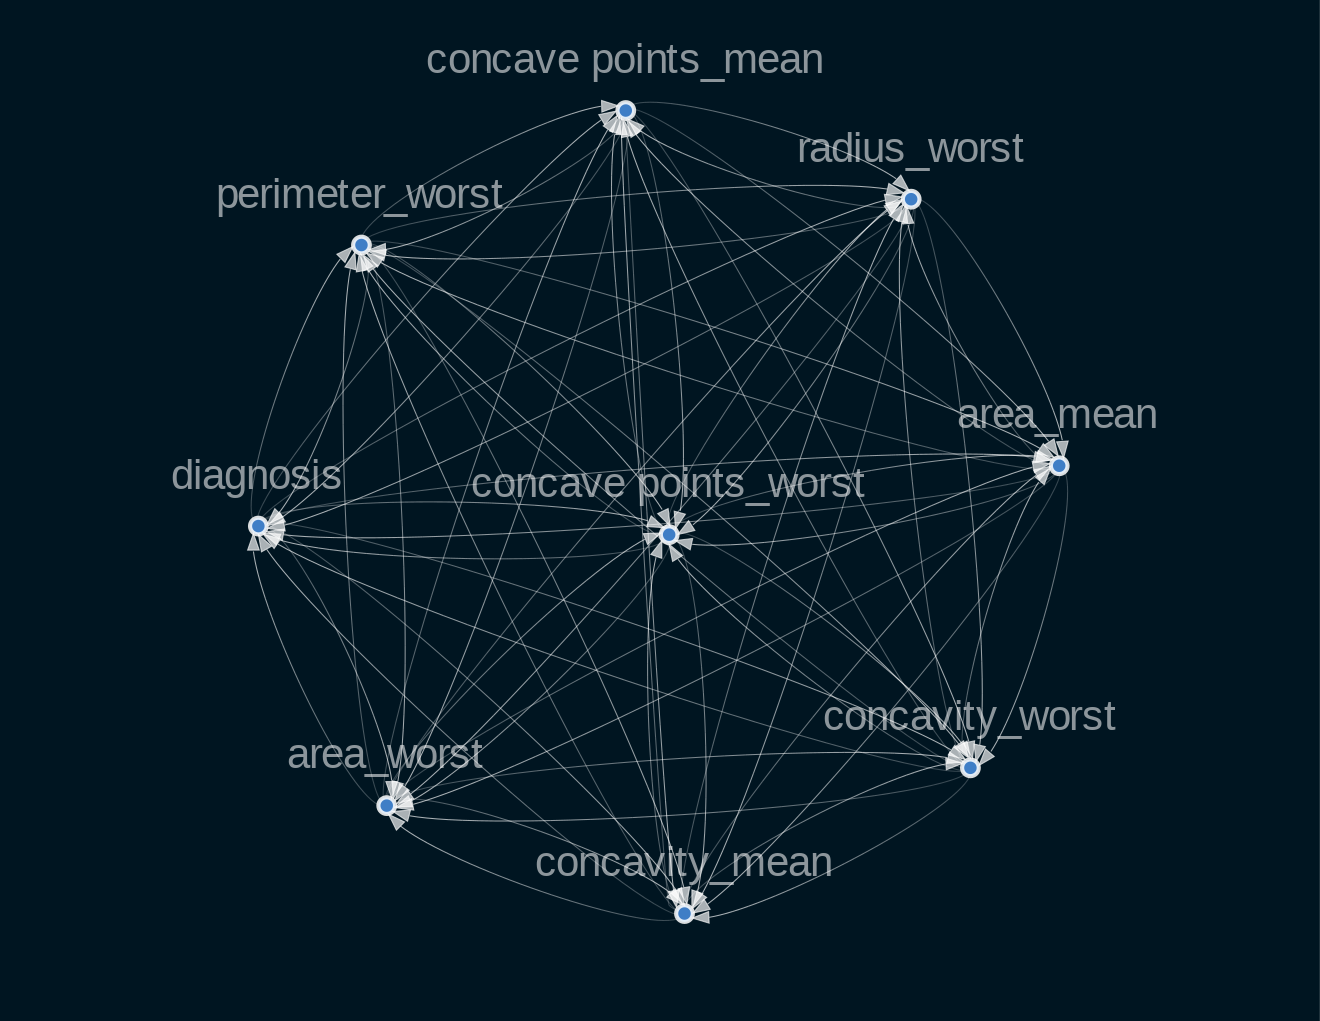

In [460]:
viz = plot_structure(
    sm,
    graph_attributes={"scale": "2"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

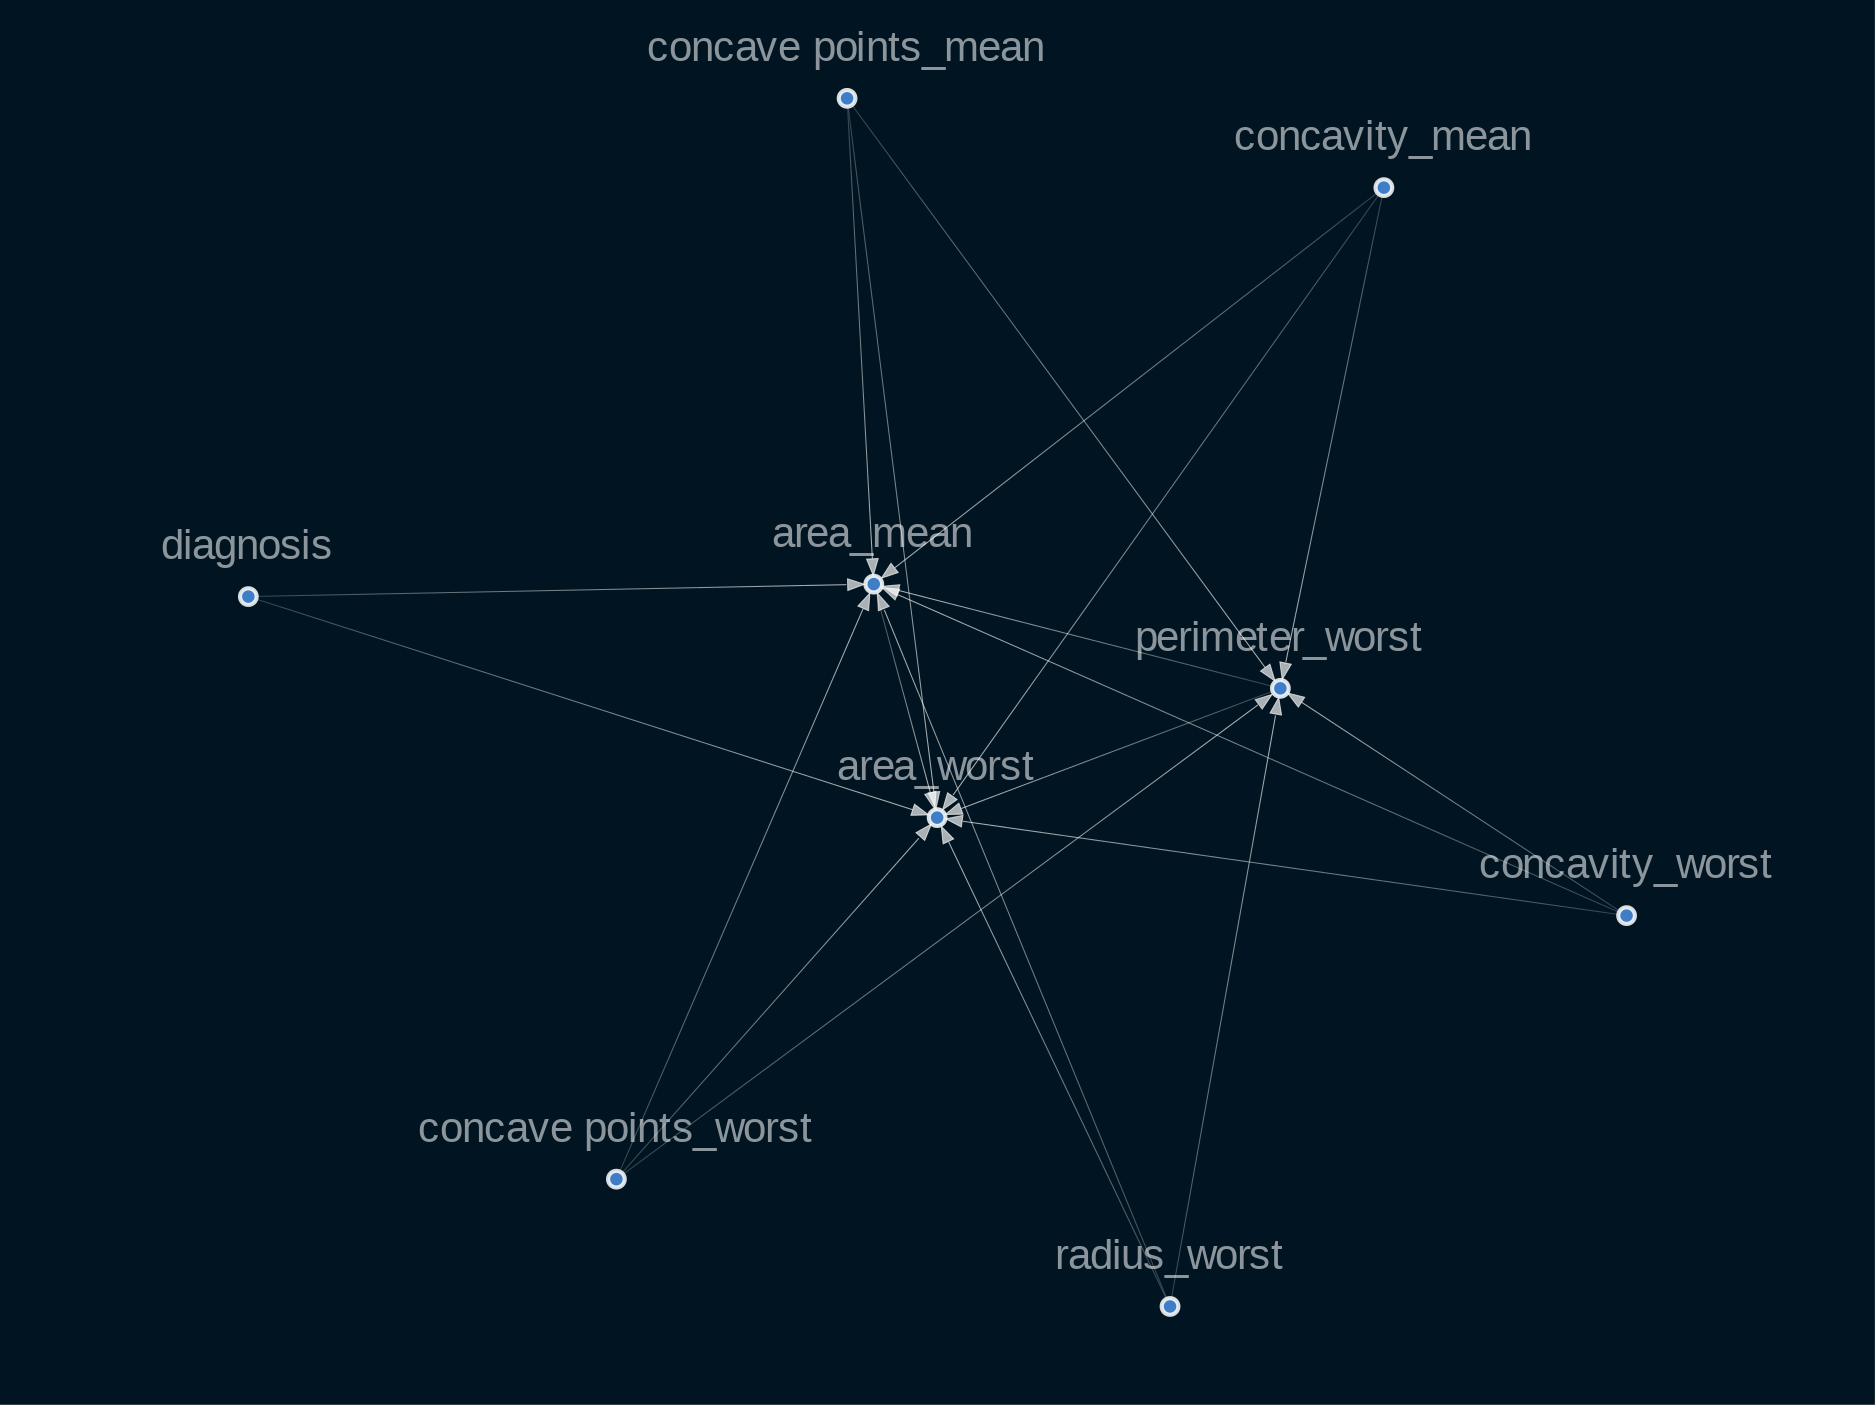

In [461]:
#remove edges with threshold below 0.8
sm.remove_edges_below_threshold(0.8)
viz = plot_structure(
    sm,
    graph_attributes={"scale": "2"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

'diagnosis' is having a direct effect on 'area_worst' and 'area_mean'. This does not make sense because 'diagnosis' is what we want the outcome to be.

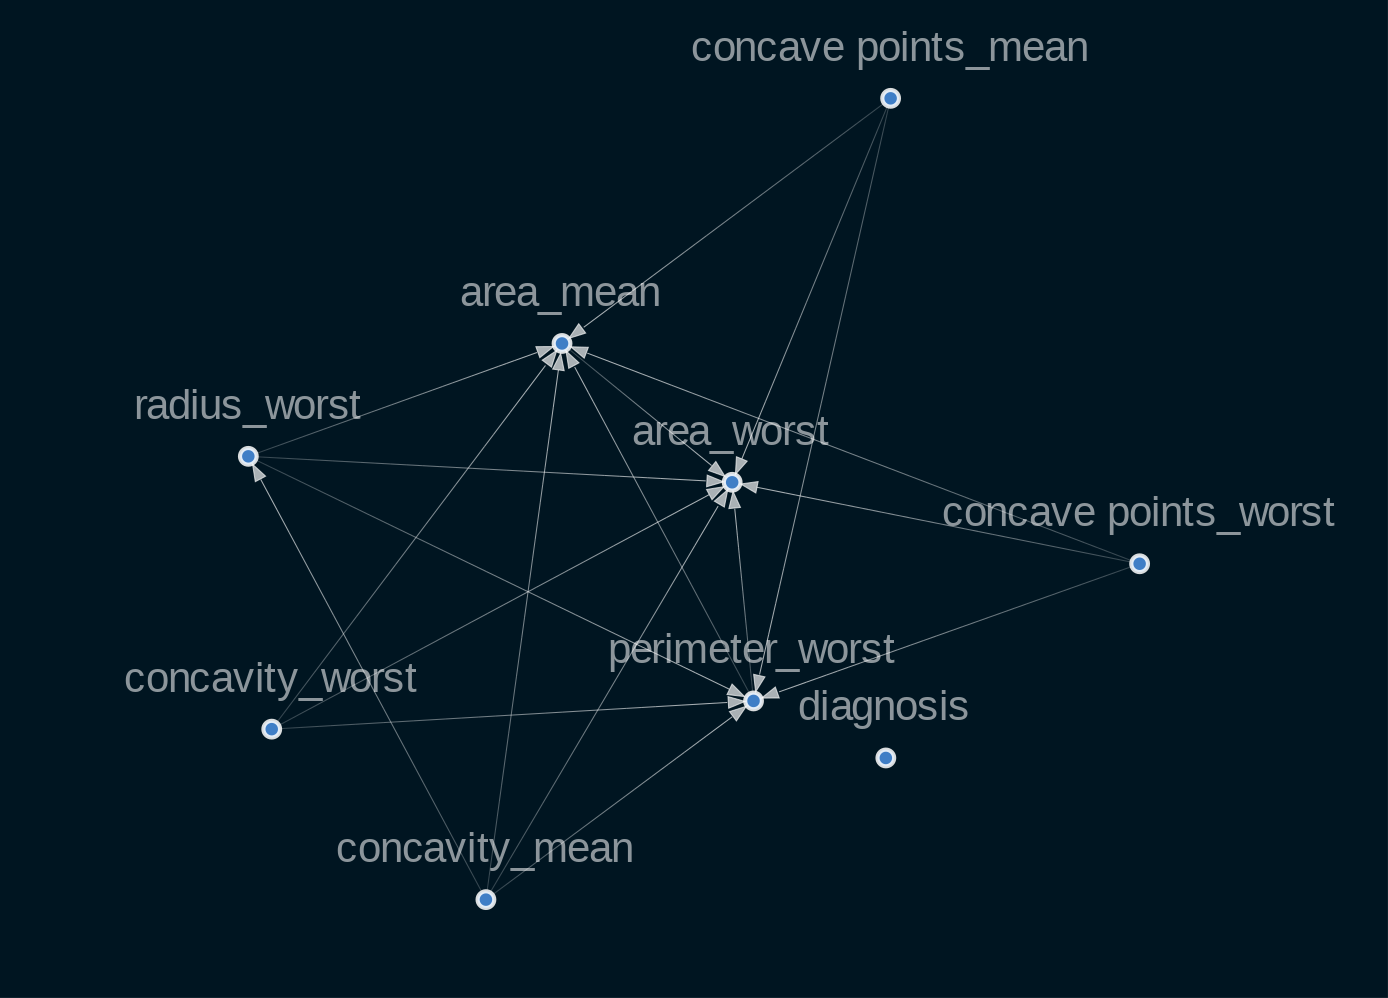

In [462]:
#we construct a new causal graph but this time,we put a constrain on 'diagnosis'
#sm.remove_edges_below_threshold(0.8)
sm_constrained = from_pandas(df, tabu_parent_nodes=["diagnosis"], w_threshold=0.8)
viz = plot_structure(
    sm_constrained,
    graph_attributes={"scale": "1.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

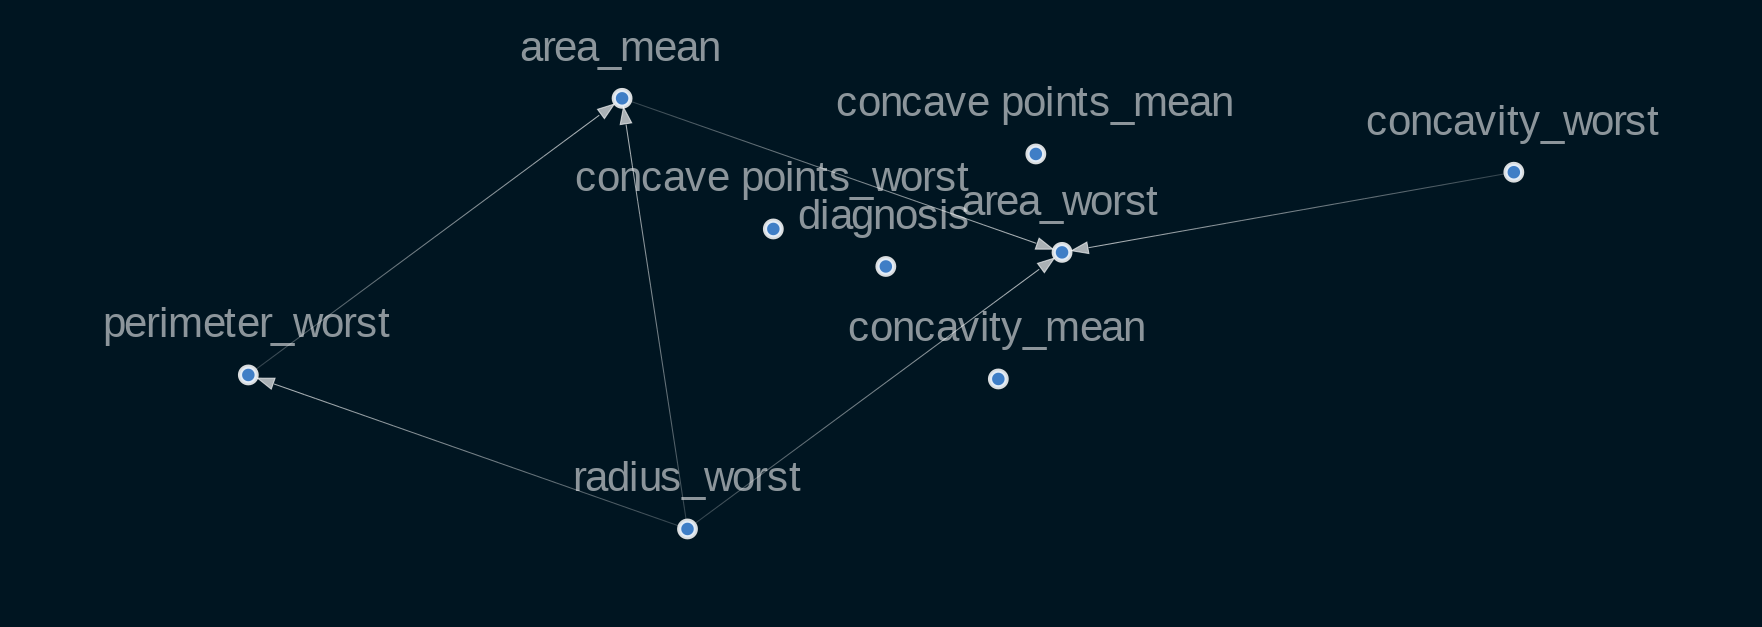

In [463]:
#generate the graph using lasso
sm_constrained_lasso = from_pandas_lasso(df, tabu_parent_nodes=["diagnosis"], w_threshold=0.8,beta=0.8)
viz = plot_structure(
    sm_constrained_lasso,
    graph_attributes={"scale": "1.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

In [464]:
#similarity between a graph plotted without lasso regularization and one plotted with lasso regularization
def jaccard_similarity(g, h):
    i = set(g).intersection(h)
    return round(len(i) / (len(g) + len(h) - len(i)),3)

jaccard_similarity(sm_constrained.edges(), sm_constrained_lasso.edges())

0.316

In [465]:
#Split the data row wise and test the model as we increase the data
df_1 = df.iloc[:100,:]
df_2 = df.iloc[:300,:]
df_3 = df.iloc[:,:] 

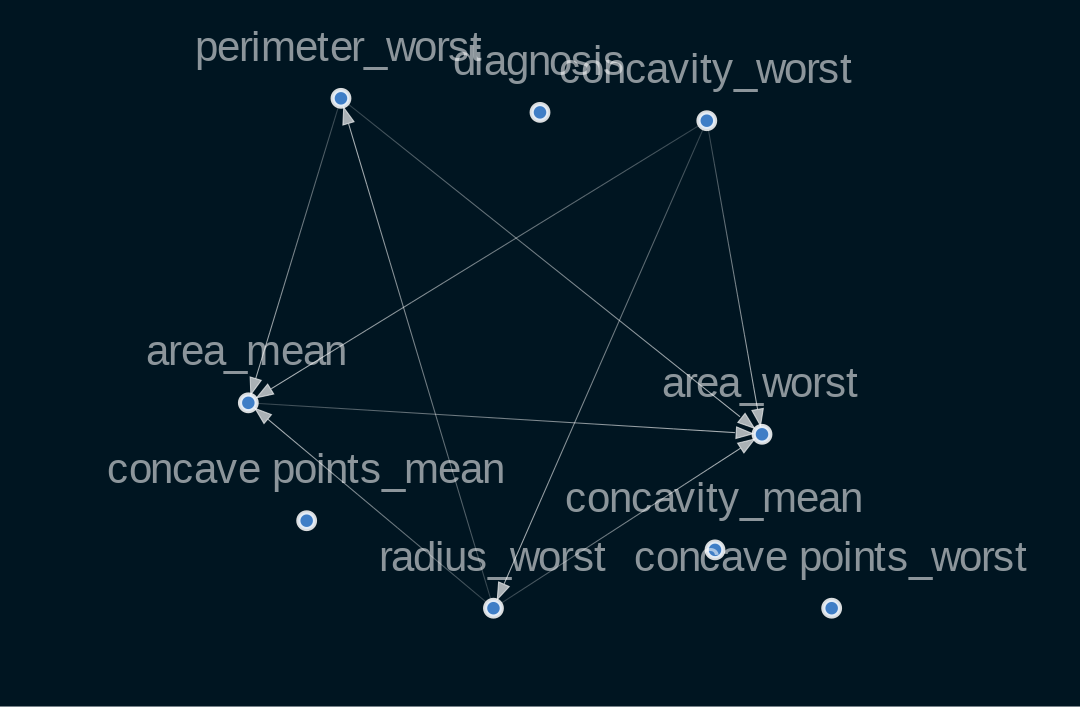

In [466]:
sm_constrained_lasso_df_1 = from_pandas_lasso(df_1, tabu_parent_nodes=["diagnosis"], w_threshold=0.8,beta=0.8)
viz = plot_structure(
    sm_constrained_lasso_df_1,
    graph_attributes={"scale": "1.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

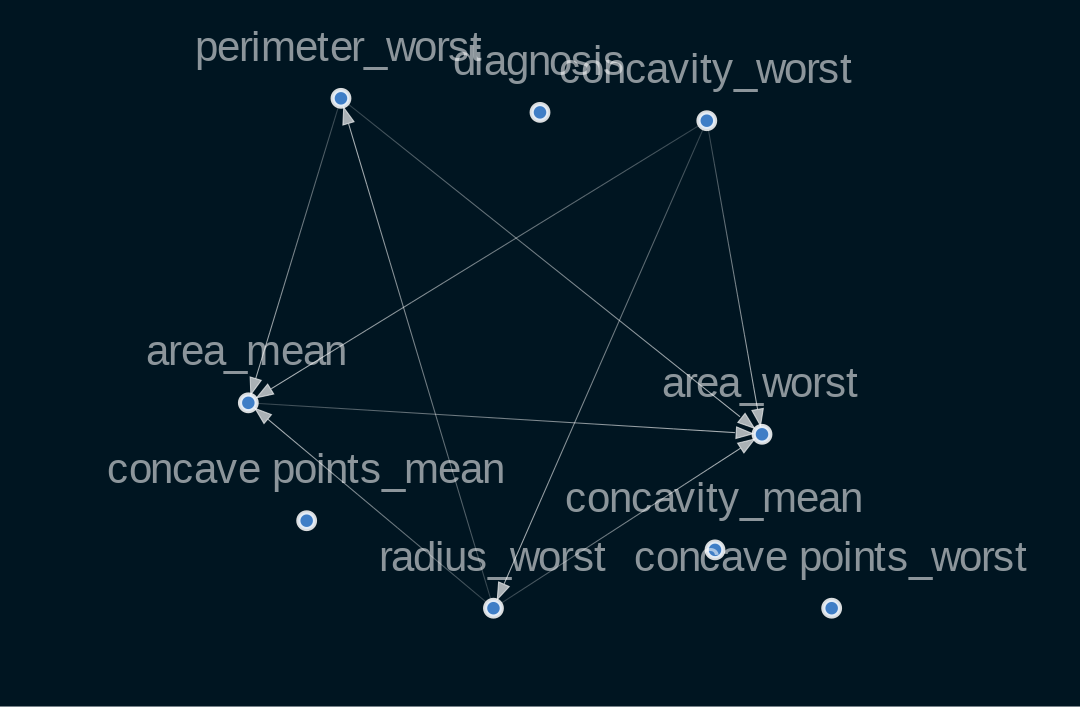

In [467]:
sm_constrained_lasso_df_2 = from_pandas_lasso(df_2, tabu_parent_nodes=["diagnosis"], w_threshold=0.8,beta=0.8)
viz = plot_structure(
    sm_constrained_lasso_df_2,
    graph_attributes={"scale": "1.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

In [468]:
# similarity between df_1 and df_2
jaccard_similarity(sm_constrained_lasso_df_1.edges(), sm_constrained_lasso_df_2.edges())

1.0

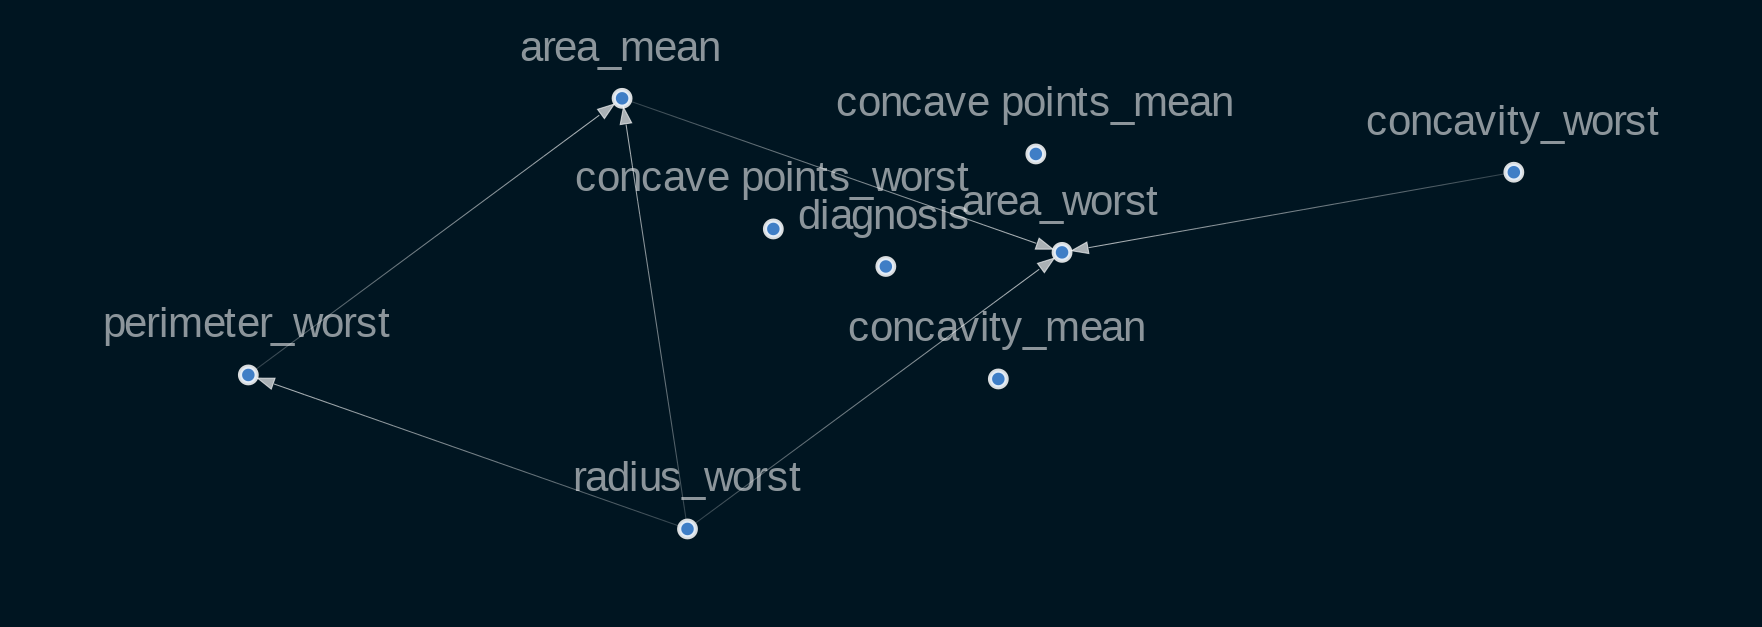

In [469]:
sm_constrained_lasso_df_3 = from_pandas_lasso(df_3, tabu_parent_nodes=["diagnosis"], w_threshold=0.8,beta=0.8)
viz = plot_structure(
    sm_constrained_lasso_df_3,
    graph_attributes={"scale": "1.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

In [470]:
# similarity between df_2 and df_3
jaccard_similarity(sm_constrained_lasso_df_2.edges(), sm_constrained_lasso_df_3.edges())

0.667

In [471]:
#add the following relations to the graph 
sm_constrained_lasso.add_edge("concave points_mean", "diagnosis")
sm_constrained_lasso.add_edge("concave points_worst", "diagnosis")
sm_constrained_lasso.add_edge("concavity_mean", "diagnosis")
sm_constrained_lasso.add_edge("area_worst", "diagnosis")
sm_constrained_lasso.add_edge("area_mean", "diagnosis")
sm_constrained_lasso.add_edge("concavity_worst", "diagnosis")
sm_constrained_lasso.add_edge("perimeter_worst", "diagnosis")

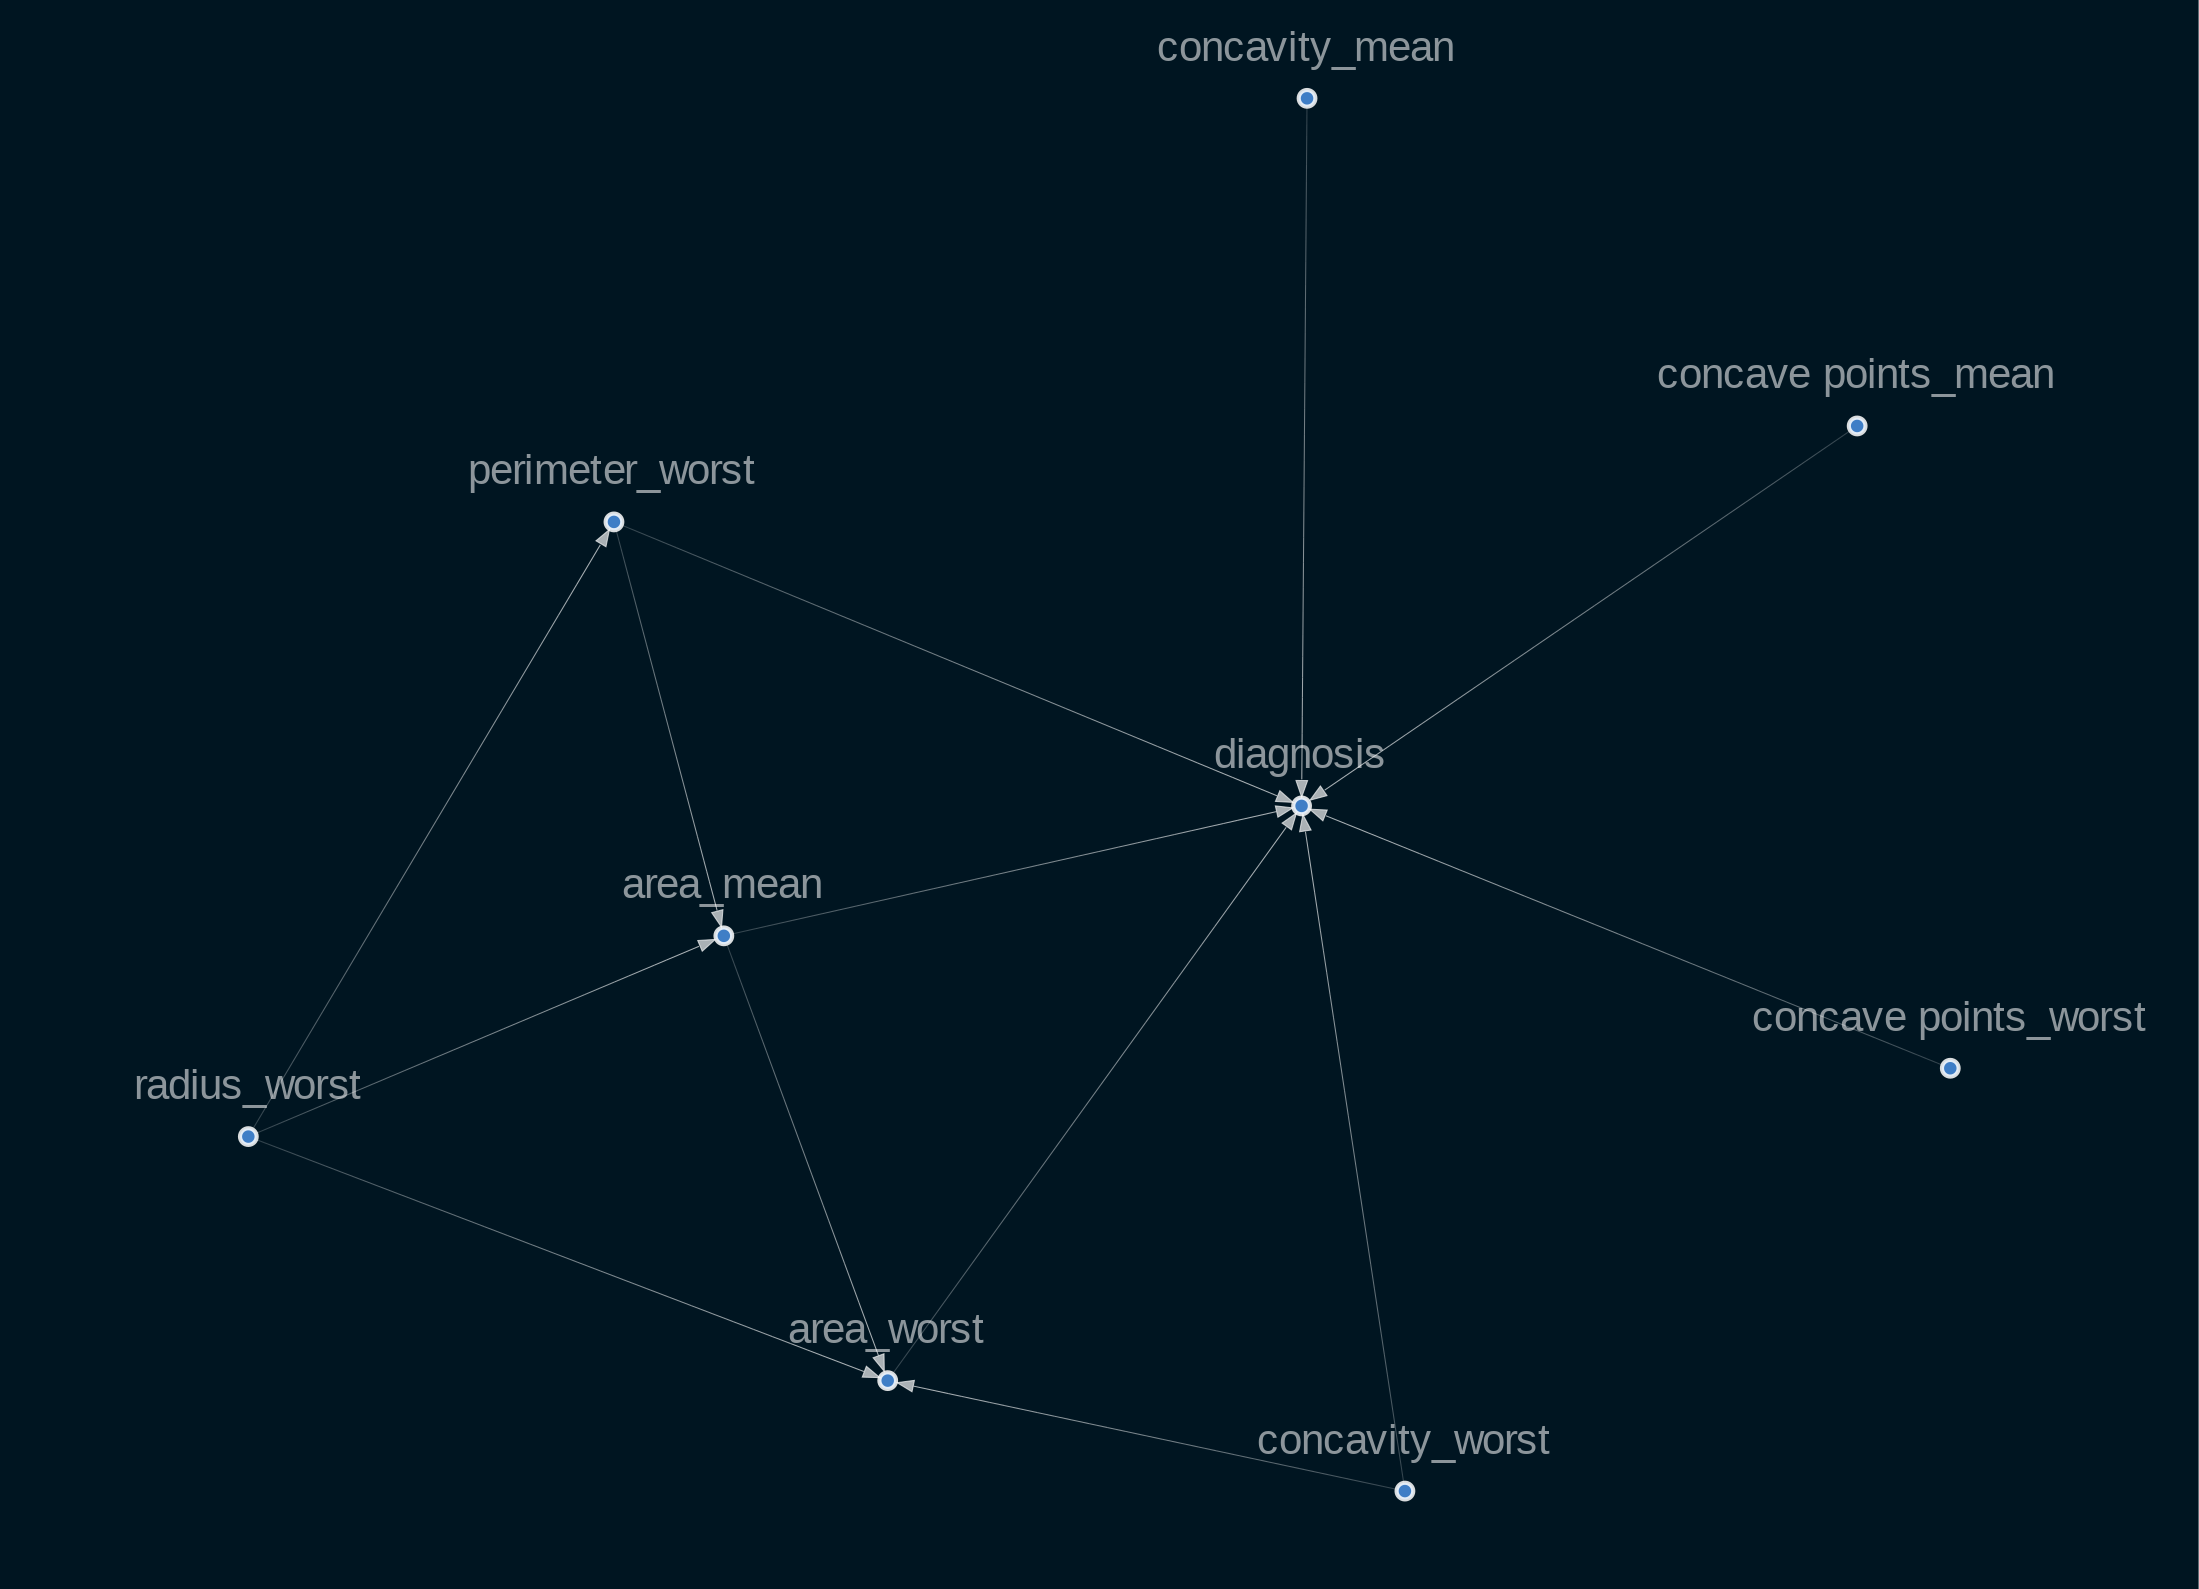

In [472]:
#plot the graph
viz = plot_structure(
    sm_constrained_lasso,
    graph_attributes={"scale": "2.0"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

In [473]:
from causalnex.network import BayesianNetwork

bn = BayesianNetwork(sm)

In [474]:
discretised_data = df.copy()

data_vals = {col: df[col].unique() for col in df.columns}


In [475]:
diagnosis_map = {v:'benign' if v == [str(0)]
                 else 'malignant' for v in data_vals['diagnosis']}
discretised_data["diagnosis"] = discretised_data["diagnosis"].map(diagnosis_map)
discretised_data.tail()

,diagnosis,area_mean,concavity_mean,concave points_mean,radius_worst,perimeter_worst,area_worst,concavity_worst,concave points_worst
564,malignant,1479.0,0.24390,0.13890,25.450,166.10,2027.0,0.4107,0.2216
565,malignant,1261.0,0.14400,0.09791,23.690,155.00,1731.0,0.3215,0.1628
566,malignant,858.1,0.09251,0.05302,18.980,126.70,1124.0,0.3403,0.1418
567,malignant,1265.0,0.35140,0.15200,25.740,184.60,1821.0,0.9387,0.2650
568,malignant,181.0,0.00000,0.00000,9.456,59.16,268.6,0.0000,0.0000


In [476]:
for i in list(discretised_data.columns[1:]):
  map = {v: 'small' if v <= (discretised_data[str(i)].max()-discretised_data[str(i)].min())/2
         else 'large' for v in data_vals[str(i)]}
  discretised_data[str(i)] = discretised_data[str(i)].map(map)

In [477]:
discretised_data.tail()

,diagnosis,area_mean,concavity_mean,concave points_mean,radius_worst,perimeter_worst,area_worst,concavity_worst,concave points_worst
564,malignant,large,large,large,large,large,small,small,large
565,malignant,large,small,small,large,large,small,small,large
566,malignant,small,small,small,large,large,small,small,small
567,malignant,large,large,large,large,large,small,large,large
568,malignant,small,small,small,small,small,small,small,small


In [478]:
from causalnex.network import BayesianNetwork
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score

bn = BayesianNetwork(sm_constrained_lasso)

train, test = train_test_split(discretised_data, train_size=0.8, test_size=0.2, random_state=7)
bn = bn.fit_node_states(discretised_data)
bn = bn.fit_cpds(train, method="BayesianEstimator", bayes_prior="K2")
pred = bn.predict(test, 'diagnosis')
true = np.where(test['diagnosis'] == 'malignant', 1, 0)
pred = np.where(pred == 'malignant', 1, 0)


print('Recall: {:.2f}'.format(recall_score(y_true=true, y_pred=pred)))
print('F1: {:.2f} '.format(f1_score(y_true=true, y_pred=pred)))
print('Accuracy: {:.2f} '.format(accuracy_score(y_true=true, y_pred=pred)))
print('Precision: {:.2f} '.format(precision_score(y_true=true, y_pred=pred)))

Recall: 1.00
F1: 1.00 
Accuracy: 1.00 
Precision: 1.00 


From the metrics, the model is probably overfitting but due to limited time.I will stop here.